In [106]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
# Load data
ground_truth = pd.read_csv("../source_data/test_preprocess.csv")
predictions = {
    "SVM": pd.read_csv('../evaluation/svm_predictions.csv'),
    "IndoBERT": pd.read_csv('../evaluation/bert_predictions.csv'),
    # zero-shot models
    "GPT-3.5 Turbo Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-3.5-turbo_predictions.csv'),
    "GPT-4 Turbo Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-4o_predictions.csv'),
    # few-shot models
    "GPT-3.5 Turbo Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-3.5-turbo_predictions.csv'),
    "GPT-4 Turbo Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-4o_predictions.csv'),
    
}

# Configuration
aspect_keys = ["ac", "air_panas", "bau", "general", "kebersihan", 
               "linen", "service", "sunrise_meal", "tv", "wifi"]

def evaluate_model(true_df, pred_df, model_name):
    """Core evaluation function for a single model"""
    merged = true_df.merge(pred_df, on="review", suffixes=('_true', '_pred'))
    results = []
    
    for aspect in aspect_keys:
        y_true = merged[f"{aspect}_true"]
        y_pred = merged[f"{aspect}_pred"]
        
        report = classification_report(y_true, y_pred, 
                                      target_names=['neg', 'pos', 'neut'],
                                      output_dict=True)
        
        results.append({
            'model': model_name,
            'aspect': aspect,
            'accuracy': accuracy_score(y_true, y_pred),
            'macro_precision': report['macro avg']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'neg_precision': report['neg']['precision'],
            'neg_recall': report['neg']['recall'],
            'neg_f1': report['neg']['f1-score'],
            'pos_precision': report['pos']['precision'],
            'pos_recall': report['pos']['recall'],
            'pos_f1': report['pos']['f1-score'],
            'neut_precision': report['neut']['precision'],
            'neut_recall': report['neut']['recall'],
            'neut_f1': report['neut']['f1-score'],
            'support': report['weighted avg']['support']
        })
    
    return pd.DataFrame(results)

# Main evaluation pipeline
all_results = []
for model_name, pred_df in predictions.items():
    print(f"Evaluating {model_name}...")
    model_results = evaluate_model(ground_truth, pred_df, model_name)
    all_results.append(model_results)

# Generate key outputs
full_results = pd.concat(all_results, ignore_index=True)

Evaluating SVM...
Evaluating IndoBERT...
Evaluating GPT-3.5 Turbo Zero-Shot...
Evaluating GPT-4 Turbo Zero-Shot...
Evaluating GPT-4o Zero-Shot...
Evaluating GPT-3.5 Turbo Few-Shot...
Evaluating GPT-4 Turbo Few-Shot...
Evaluating GPT-4o Few-Shot...


In [108]:
# 1. Model Comparison Table
model_comparison = full_results.groupby('model').agg({
    'accuracy': 'mean',
    'macro_precision': 'mean',
    'macro_recall': 'mean',
    'macro_f1': 'mean',
    'weighted_precision': 'mean',
    'weighted_recall': 'mean',
    'weighted_f1': 'mean',
    'neg_precision': 'mean',
    'neg_recall': 'mean',
    'neg_f1': 'mean',
    'pos_precision': 'mean',
    'pos_recall': 'mean',
    'pos_f1': 'mean',
    'neut_precision': 'mean',
    'neut_recall': 'mean',
    'neut_f1': 'mean',
    'support': 'mean'
}).reset_index()

print("\n=== AVG Model Comparison ===")
model_comparison.round(4)


=== AVG Model Comparison ===


,model,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,neg_precision,neg_recall,neg_f1,pos_precision,pos_recall,pos_f1,neut_precision,neut_recall,neut_f1,support
0,GPT-3.5 Turbo Few-Shot,0.9154,0.8143,0.8193,0.8058,0.9221,0.9154,0.9160,0.7962,0.7544,0.7505,0.9399,0.9559,0.9469,0.7068,0.7475,0.7200,286.0
1,GPT-3.5 Turbo Zero-Shot,0.9150,0.7955,0.7810,0.7814,0.9170,0.9150,0.9140,0.7833,0.7069,0.7338,0.9360,0.9612,0.9480,0.6671,0.6748,0.6624,286.0
2,GPT-4 Turbo Few-Shot,0.9329,0.8414,0.8702,0.8340,0.9505,0.9329,0.9362,0.8384,0.8315,0.8036,0.9620,0.9543,0.9553,0.7236,0.8249,0.7431,286.0
3,GPT-4 Turbo Zero-Shot,0.9283,0.8276,0.8771,0.8307,0.9514,0.9283,0.9328,0.8327,0.8529,0.8118,0.9677,0.9440,0.9514,0.6823,0.8345,0.7288,286.0
4,GPT-4o Few-Shot,0.9455,0.8424,0.8603,0.8391,0.9513,0.9455,0.9455,0.8549,0.8148,0.8220,0.9625,0.9703,0.9654,0.7099,0.7959,0.7299,286.0
5,GPT-4o Zero-Shot,0.8909,0.7916,0.6410,0.6777,0.8980,0.8909,0.8826,0.8526,0.6123,0.6871,0.8947,0.9739,0.9307,0.6275,0.3367,0.4152,286.0
6,IndoBERT,0.9608,0.8129,0.8093,0.8060,0.9595,0.9608,0.9595,0.8238,0.8362,0.8269,0.9787,0.9761,0.9774,0.6363,0.6155,0.6136,286.0
7,SVM,0.9350,0.7000,0.6718,0.6724,0.9293,0.9350,0.9305,0.7453,0.7450,0.7435,0.9583,0.9741,0.9660,0.3962,0.2965,0.3077,286.0


# Viz

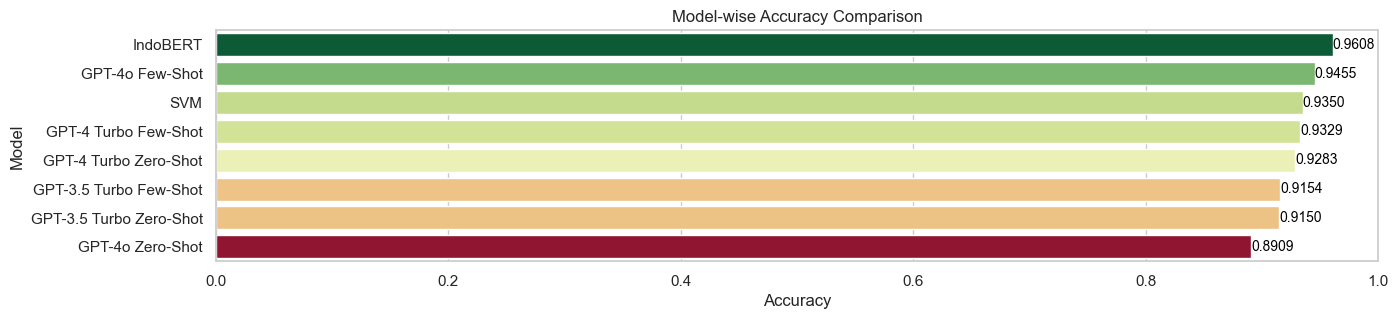

In [109]:
# 1. Model-wise Accuracy Comparison
sns.set_theme(style="whitegrid")
model_comparison = model_comparison.sort_values("accuracy", ascending=False)
norm = plt.Normalize(model_comparison["accuracy"].min(), model_comparison["accuracy"].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
colors = [sm.to_rgba(val) for val in model_comparison["accuracy"]]
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(data=model_comparison, x="accuracy", y="model", palette=colors, ax=ax)

# Annotate bars with accuracy values
for p in ax.patches:
    ax.annotate(f"{p.get_width():.4f}",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

ax.set_xlabel("Accuracy")
ax.set_ylabel("Model")
ax.set_title("Model-wise Accuracy Comparison")
ax.set_xlim(0, 1)
plt.show()

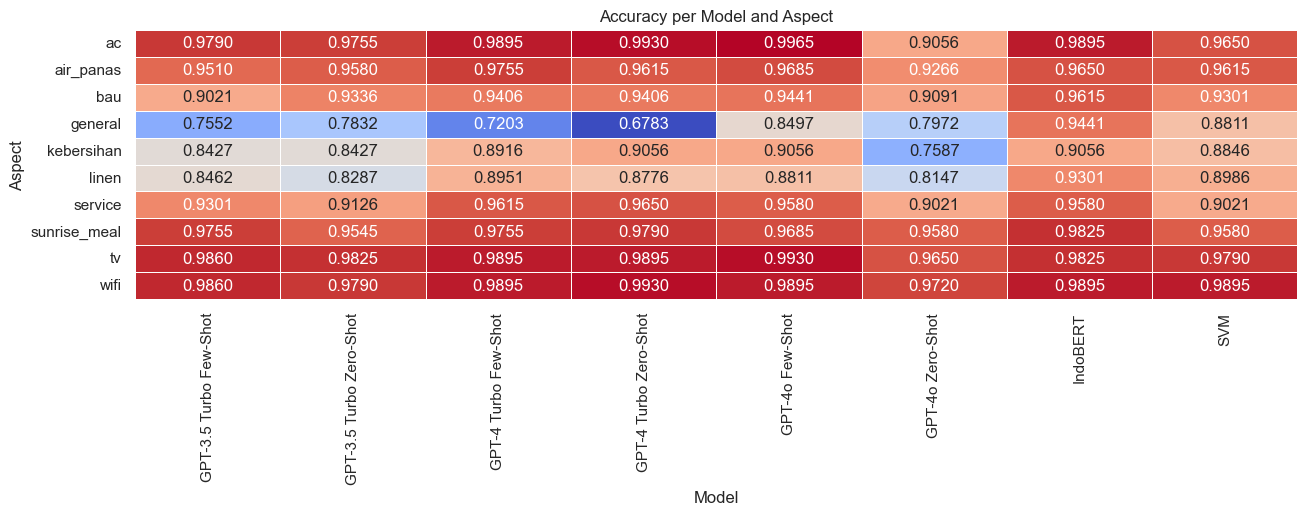

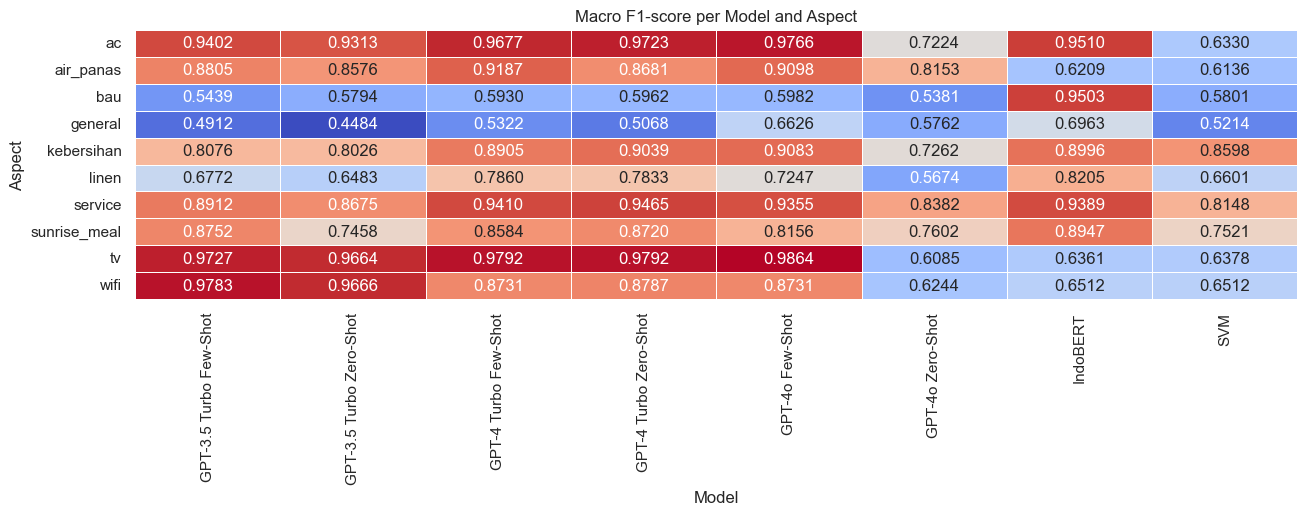

In [110]:
# 2. Heatmap for Macro Accuracy & F1-score per Model and Aspect
plt.figure(figsize=(15, 3.5))
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="accuracy", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, cbar=False)
plt.title("Accuracy per Model and Aspect")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()

plt.figure(figsize=(15, 3.5))
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="macro_f1", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, cbar=False)
plt.title("Macro F1-score per Model and Aspect")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()

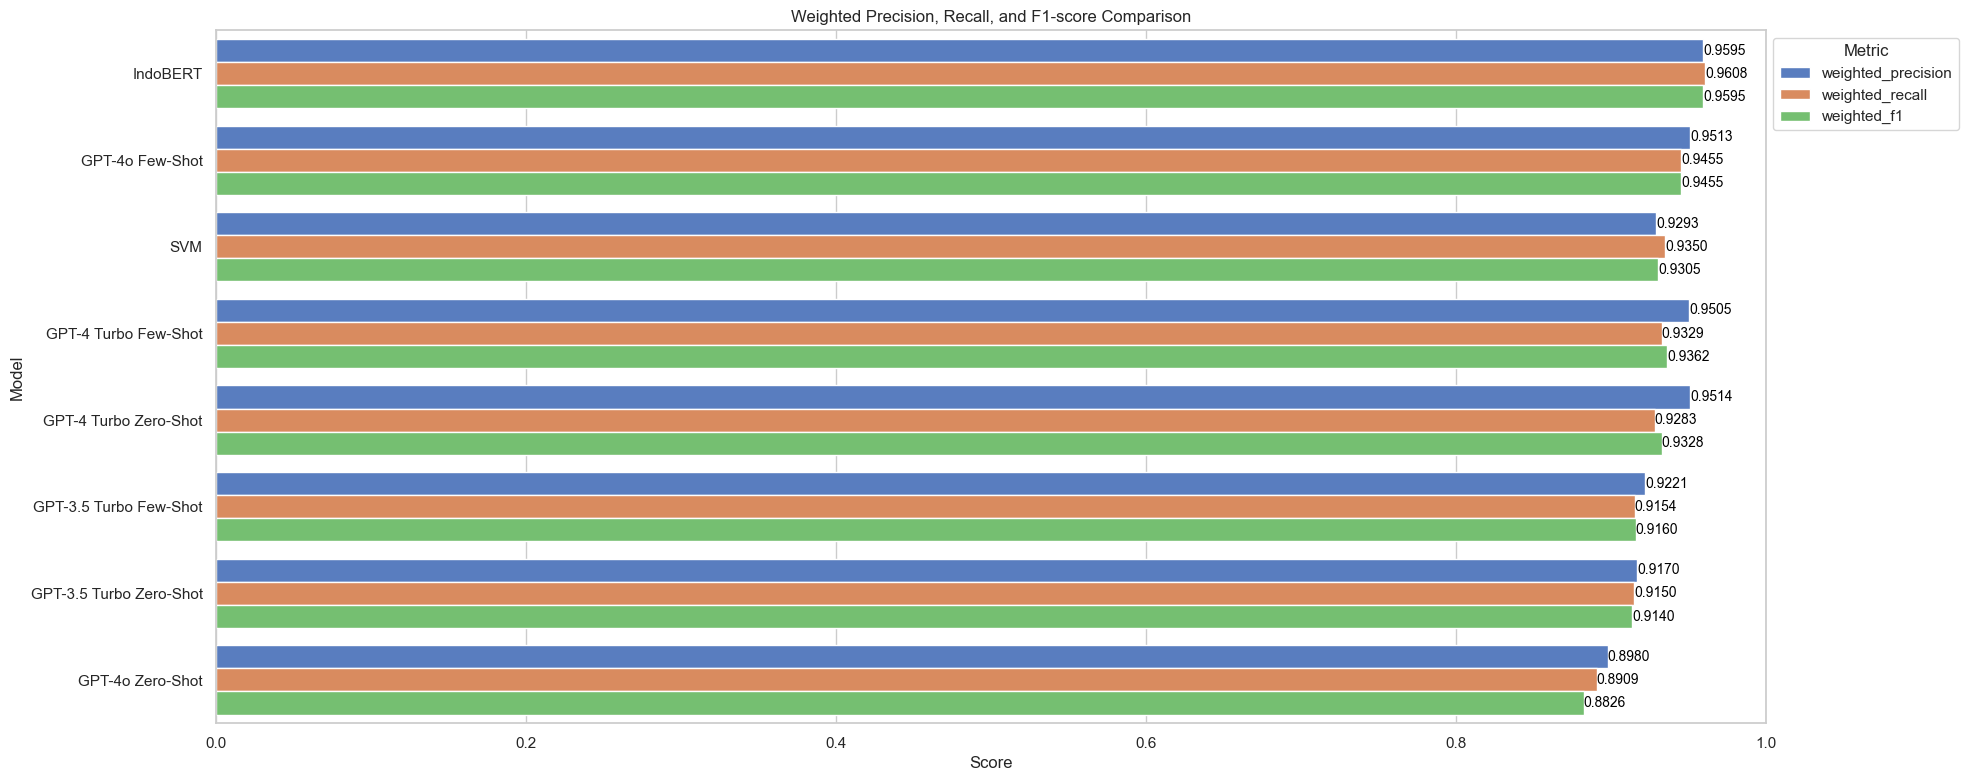

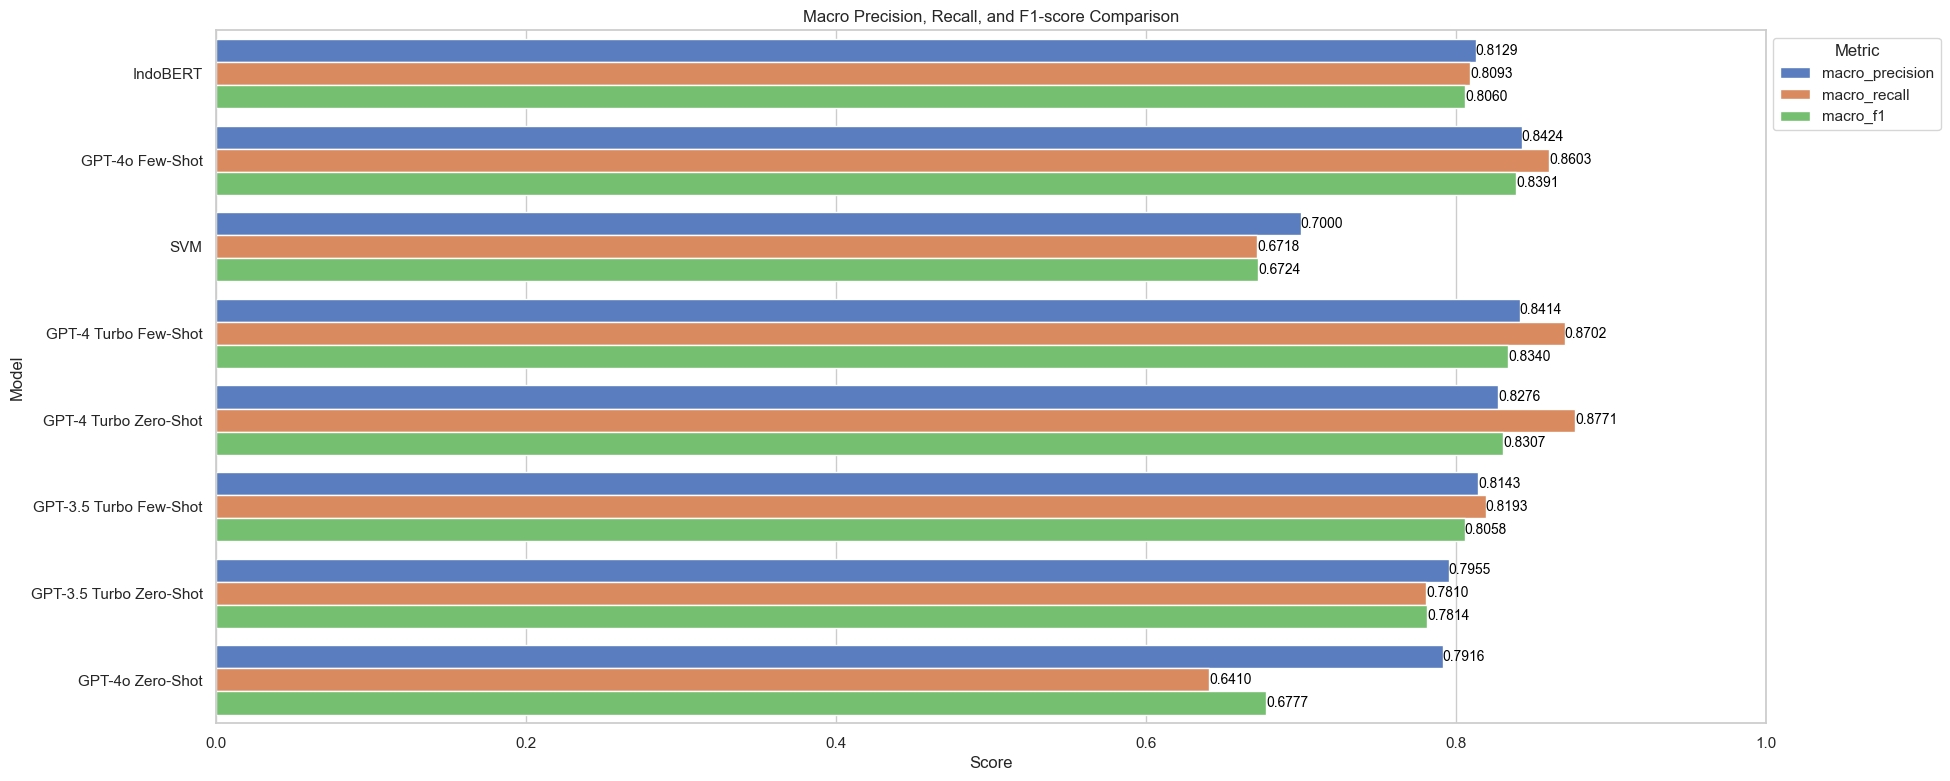

In [118]:
def add_value_labels(ax, decimal_places=4):
    """Adds value labels to bars in a barplot, skipping zeros."""
    for p in ax.patches:
        if p.get_width() > 0: 
            ax.annotate(f'{p.get_width():.{decimal_places}f}',
                        (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='left', va='center', fontsize=10, color='black')

# First plot: Weighted metrics
metrics = ["weighted_precision", "weighted_recall", "weighted_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")
plt.figure(figsize=(20, 9))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Weighted Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# Second plot: Macro metrics
metrics = ["macro_precision", "macro_recall", "macro_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")
plt.figure(figsize=(20, 9))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Macro Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

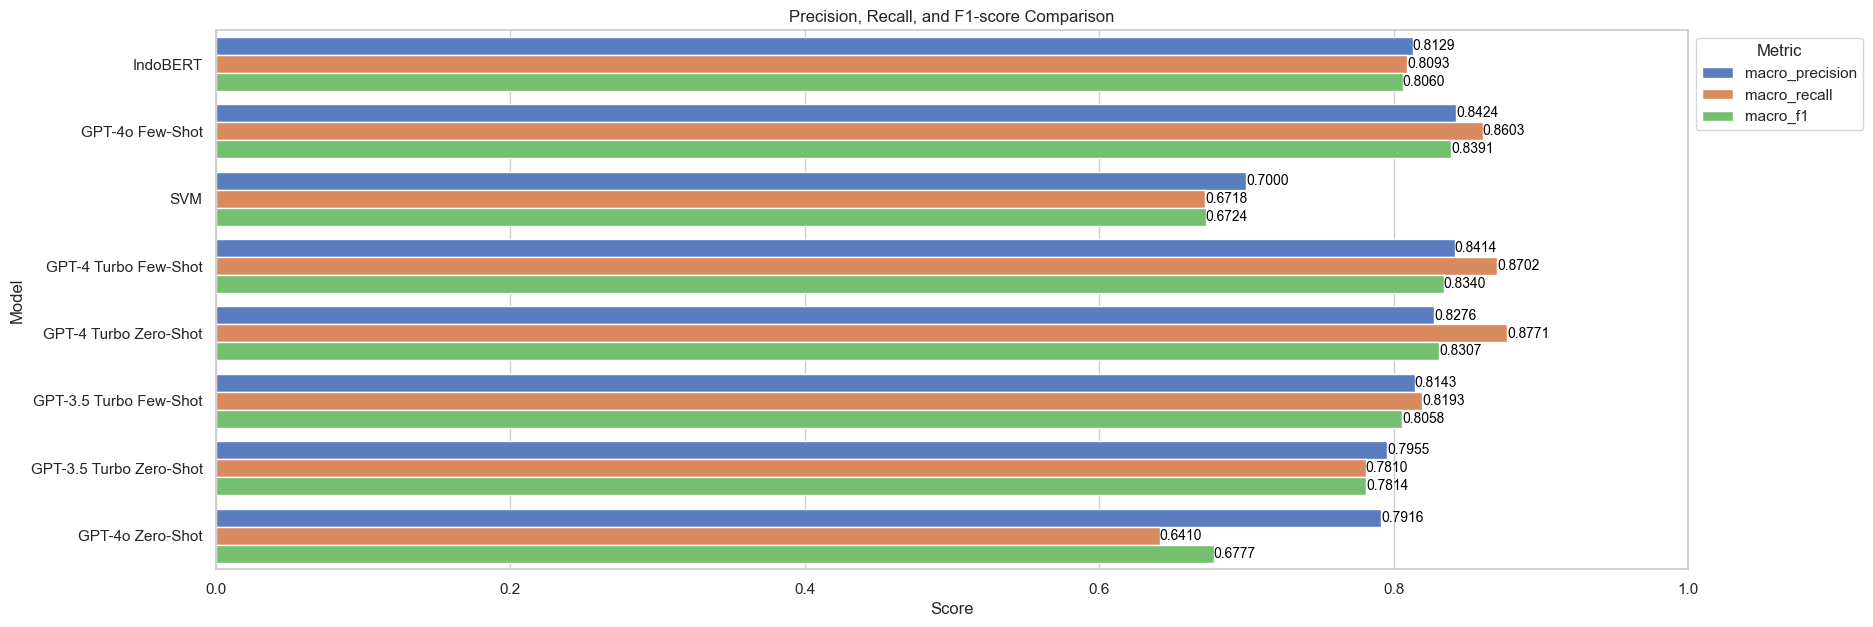

In [112]:
# Second plot: Macro metrics
metrics = ["macro_precision", "macro_recall", "macro_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")

plt.figure(figsize=(19, 7))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


In [113]:
melted_df

,model,Metric,Score
0,IndoBERT,macro_precision,0.812938
1,GPT-4o Few-Shot,macro_precision,0.842442
2,SVM,macro_precision,0.699951
3,GPT-4 Turbo Few-Shot,macro_precision,0.841351
4,GPT-4 Turbo Zero-Shot,macro_precision,0.827555
5,GPT-3.5 Turbo Few-Shot,macro_precision,0.814313
6,GPT-3.5 Turbo Zero-Shot,macro_precision,0.795476
7,GPT-4o Zero-Shot,macro_precision,0.791624
8,IndoBERT,macro_recall,0.809283
9,GPT-4o Few-Shot,macro_recall,0.860294


In [114]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # Display the DataFrame
# display(aspect_performance)

# # Reset to default after displaying
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')